In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from qiskit import *
from qiskit.pulse import *
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import plot_histogram
import qiskit.pulse.pulse_lib as pulse_lib
import qiskit.tools.jupyter

In [3]:
IBMQ.load_account() # Load account from disk
IBMQ.providers()    # List all available providers

[<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>,
 <AccountProvider for IBMQ(hub='ibm-q-ornl', group='bes-qis', project='argonne')>]

In [4]:
provider = IBMQ.get_provider(group='bes-qis')
backend = provider.get_backend('ibmq_boeblingen')
system = pulse.PulseChannelSpec.from_backend(backend)
config = backend.configuration()
defaults = backend.defaults()
cmd_def = pulse.CmdDef.from_defaults(backend.defaults().cmd_def, backend.defaults().pulse_library)
measure = cmd_def.get('measure', qubits=config.meas_map[0])

In [5]:
%qiskit_job_watcher

Accordion(children=(VBox(layout=Layout(max_width='610px', min_width='610px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

---
## Try finding Chevron

In [35]:
num_drive_amps = 15
drive_amps = np.linspace(0.05, 0.45, num_drive_amps)
drive_samples = 128
drive_sigma = 16
print(drive_amps)

num_drive_lo_freqs = 11
# anharmonicity is about between -100 MHz and -300 MHz (going up to 500 though)
drive_lo_freqs = np.array([4.9469008, 4.9269008, 4.9069008, 4.8869008, 4.8669008, 4.8469008,
                           4.8269008, 4.8069008, 4.7869008, 4.7669008, 4.7469008])
print(drive_lo_freqs)

[0.05       0.07857143 0.10714286 0.13571429 0.16428571 0.19285714
 0.22142857 0.25       0.27857143 0.30714286 0.33571429 0.36428571
 0.39285714 0.42142857 0.45      ]
[4.9469008 4.9269008 4.9069008 4.8869008 4.8669008 4.8469008 4.8269008
 4.8069008 4.7869008 4.7669008 4.7469008]


In [ ]:
jobs = []

for drive_lo_freq in drive_lo_freqs:
    schedules = []
    schedule_los = []

    for drive_amp in drive_amps:
        schedule = pulse.Schedule(name='Rabi Experiment at drive amp = %s' % drive_amp)
        schedule |= cmd_def.get('x', qubits=[0])
        rabi_pulse = pulse_lib.gaussian(duration=drive_samples,
                                        amp=drive_amp,
                                        sigma=drive_sigma,
                                        name='rabi_pulse_with_drive_amp_%s' % drive_amp)    
        schedule |= rabi_pulse(system.qubits[0].drive) << schedule.duration
        schedule |= measure << schedule.duration

        schedules.append(schedule)        
        schedule_los.append(pulse.LoConfig({system.qubits[0].drive: drive_lo_freq}))
        
    qobj = assemble(schedules, backend, shots=512, schedule_los=schedule_los)
    job = backend.run(qobj)
    
    jobs.append(job)

In [48]:
job_ids = ['5d896f7401bf92001948dcb9', '5d896f78194e3500196c601c', '5d896f7b4a13e1001863aa05',
           '5d896f7fa807ac0018bac7db', '5d896f8301bf92001948dcbb', '5d896f8701bf92001948dcbd',
           '5d896f8a1765500018c3e49a', '5d896f8d4a13e1001863aa07', '5d896f9001bf92001948dcbf',
           '5d896f94194e3500196c601e', '5d896f974a13e1001863aa09']
jobs = [backend.retrieve_job(job_id) for job_id in job_ids]

for i in range(num_drive_lo_freqs):
    print('Job %s with drive LO frequency %s: %s' % (i, drive_lo_freqs[i], jobs[i].status()))

Job 0 with drive LO frequency 4.9469008: JobStatus.DONE
Job 1 with drive LO frequency 4.9269008: JobStatus.DONE
Job 2 with drive LO frequency 4.9069008: JobStatus.DONE
Job 3 with drive LO frequency 4.8869008: JobStatus.DONE
Job 4 with drive LO frequency 4.8669008: JobStatus.DONE
Job 5 with drive LO frequency 4.8469008: JobStatus.DONE
Job 6 with drive LO frequency 4.8269008: JobStatus.DONE
Job 7 with drive LO frequency 4.8069008: JobStatus.DONE
Job 8 with drive LO frequency 4.7869008: JobStatus.DONE
Job 9 with drive LO frequency 4.7669008: JobStatus.DONE
Job 10 with drive LO frequency 4.7469008: JobStatus.DONE


In [89]:
chevron_data = np.zeros((num_drive_amps, num_drive_lo_freqs), dtype=np.float64)

for i, job in enumerate(jobs):
    result = job.result()

    for j in range(num_drive_amps):
        counts = result.get_counts(j)
        num_ones = sum([freq for (bitstring, freq) in counts.items() if bitstring.endswith('1')])
        chevron_data[j, i] = num_ones / 512

Text(0,0.5,'Pulse amplitude, a.u.')

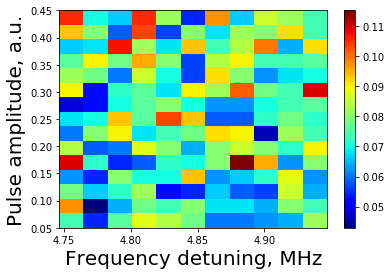

In [90]:
plt.imshow(chevron_data,
           extent=[drive_lo_freqs.min(), drive_lo_freqs.max(), drive_amps.min(), drive_amps.max()],
           cmap='jet',
           origin='lowest', aspect='auto')
plt.colorbar()
plt.xlabel('Frequency detuning, MHz', fontsize=20)
plt.ylabel('Pulse amplitude, a.u.', fontsize=20)

---
## Different range

In [8]:
num_drive_amps = 6
drive_amps = np.linspace(0.0, 0.05, num_drive_amps)
drive_samples = 128
drive_sigma = 16
print(drive_amps)

num_drive_lo_freqs = 15
drive_lo_freqs = np.linspace(backend.defaults().qubit_freq_est[0], config.qubit_lo_range[0][0], num_drive_lo_freqs)
print(drive_lo_freqs)

[0.   0.01 0.02 0.03 0.04 0.05]
[5.0469008  5.02547222 5.00404365 4.98261508 4.96118651 4.93975794
 4.91832937 4.8969008  4.87547222 4.85404365 4.83261508 4.81118651
 4.78975794 4.76832937 4.7469008 ]


In [9]:
jobs = []
job_ids = []

for drive_lo_freq in drive_lo_freqs:
    schedules = []
    schedule_los = []

    for drive_amp in drive_amps:
        schedule = pulse.Schedule(name='Rabi Experiment at drive amp = %s' % drive_amp)
        schedule |= cmd_def.get('x', qubits=[0])
        rabi_pulse = pulse_lib.gaussian(duration=drive_samples,
                                        amp=drive_amp,
                                        sigma=drive_sigma,
                                        name='rabi_pulse_with_drive_amp_%s' % drive_amp)    
        schedule |= rabi_pulse(system.qubits[0].drive) << schedule.duration
        schedule |= measure << schedule.duration

        schedules.append(schedule)        
        schedule_los.append(pulse.LoConfig({system.qubits[0].drive: drive_lo_freq}))
        
    qobj = assemble(schedules, backend, shots=512, schedule_los=schedule_los)
    job = backend.run(qobj)
    
    jobs.append(job)
    time.sleep(1)

In [11]:
print([job.job_id() for job in jobs])

['5d898bbd47a7650019974636', '5d898bc34a13e1001863aa20', '5d898bc7a807ac0018bac7f9', '5d898bcba77e8e00199f4057', '5d898bcf48b726001ab3c40a', '5d898bd4a77e8e00199f4059', '5d898bd84a13e1001863aa22', '5d898bec1765500018c3e4ac', '5d898bf001bf92001948dcd7', '5d898bf4194e3500196c6032', '5d898bf81765500018c3e4ae', '5d898bfc91f68a001979a50f', '5d898c01a807ac0018bac7fb', '5d898c05194e3500196c6034', '5d898c0948b726001ab3c40c']


In [55]:
job_ids = ['5d898bbd47a7650019974636', '5d898bc34a13e1001863aa20', '5d898bc7a807ac0018bac7f9',
           '5d898bcba77e8e00199f4057', '5d898bcf48b726001ab3c40a', '5d898bd4a77e8e00199f4059',
           '5d898bd84a13e1001863aa22', '5d898bec1765500018c3e4ac', '5d898bf001bf92001948dcd7',
           '5d898bf4194e3500196c6032', '5d898bf81765500018c3e4ae', '5d898bfc91f68a001979a50f',
           '5d898c01a807ac0018bac7fb', '5d898c05194e3500196c6034', '5d898c0948b726001ab3c40c']

jobs = [backend.retrieve_job(job_id) for job_id in job_ids]

for i in range(num_drive_lo_freqs):
    print('Job %s with drive LO frequency %s: %s' % (i, drive_lo_freqs[i], jobs[i].status()))

Job 0 with drive LO frequency 5.046900795223616: JobStatus.DONE
Job 1 with drive LO frequency 5.025472223795044: JobStatus.DONE
Job 2 with drive LO frequency 5.004043652366473: JobStatus.DONE
Job 3 with drive LO frequency 4.982615080937902: JobStatus.DONE
Job 4 with drive LO frequency 4.96118650950933: JobStatus.DONE
Job 5 with drive LO frequency 4.939757938080759: JobStatus.DONE
Job 6 with drive LO frequency 4.918329366652188: JobStatus.DONE
Job 7 with drive LO frequency 4.896900795223615: JobStatus.DONE
Job 8 with drive LO frequency 4.875472223795044: JobStatus.DONE
Job 9 with drive LO frequency 4.854043652366473: JobStatus.DONE
Job 10 with drive LO frequency 4.832615080937901: JobStatus.DONE
Job 11 with drive LO frequency 4.81118650950933: JobStatus.DONE
Job 12 with drive LO frequency 4.789757938080759: JobStatus.DONE
Job 13 with drive LO frequency 4.768329366652187: JobStatus.DONE
Job 14 with drive LO frequency 4.746900795223616: JobStatus.DONE


In [72]:
chevron_data = np.zeros((num_drive_amps, num_drive_lo_freqs), dtype=np.float64)

for i, job in enumerate(jobs):
    result = job.result()

    for j in range(num_drive_amps):
        counts = result.get_counts(j)
        num_ones = sum([freq for (bitstring, freq) in counts.items() if bitstring.endswith('1')])
        chevron_data[j, i] = num_ones / 512

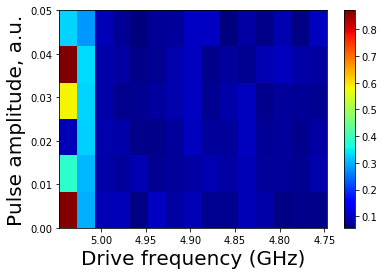

In [73]:
plt.xlabel('Drive frequency (GHz)', fontsize=20)
plt.ylabel('Pulse amplitude, a.u.', fontsize=20)
plt.imshow(chevron_data,
           extent=[drive_lo_freqs.max(), drive_lo_freqs.min(), drive_amps.min(), drive_amps.max()],
           cmap='jet',
           origin='lower', aspect='auto')
plt.colorbar()

---
## More datapoints

In [75]:
num_drive_amps = 15
drive_amps = np.linspace(0.0, 0.05, num_drive_amps)
drive_samples = 128
drive_sigma = 16
print(drive_amps)

num_drive_lo_freqs = 25
drive_lo_freqs = np.linspace(backend.defaults().qubit_freq_est[0], config.qubit_lo_range[0][0], num_drive_lo_freqs)
print(drive_lo_freqs)

[0.         0.00357143 0.00714286 0.01071429 0.01428571 0.01785714
 0.02142857 0.025      0.02857143 0.03214286 0.03571429 0.03928571
 0.04285714 0.04642857 0.05      ]
[5.0469008 5.0344008 5.0219008 5.0094008 4.9969008 4.9844008 4.9719008
 4.9594008 4.9469008 4.9344008 4.9219008 4.9094008 4.8969008 4.8844008
 4.8719008 4.8594008 4.8469008 4.8344008 4.8219008 4.8094008 4.7969008
 4.7844008 4.7719008 4.7594008 4.7469008]


In [ ]:
jobs = []
job_ids = []

for drive_lo_freq in drive_lo_freqs:
    schedules = []
    schedule_los = []

    for drive_amp in drive_amps:
        schedule = pulse.Schedule(name='Rabi Experiment at drive amp = %s' % drive_amp)
        schedule |= cmd_def.get('x', qubits=[0])
        rabi_pulse = pulse_lib.gaussian(duration=drive_samples,
                                        amp=drive_amp,
                                        sigma=drive_sigma,
                                        name='rabi_pulse_with_drive_amp_%s' % drive_amp)    
        schedule |= rabi_pulse(system.qubits[0].drive) << schedule.duration
        schedule |= measure << schedule.duration

        schedules.append(schedule)        
        schedule_los.append(pulse.LoConfig({system.qubits[0].drive: drive_lo_freq}))
        
    qobj = assemble(schedules, backend, shots=512, schedule_los=schedule_los)
    job = backend.run(qobj)

    jobs.append(job)
    time.sleep(1)

In [8]:
print([job.job_id() for job in jobs])

['5d8a532e29dcfd0011e558b0', '5d8a5333efc5a50011233768', '5d8a533779e8740011f3d960', '5d8a533c79e8740011f3d962', '5d8a534029dcfd0011e558b2', '5d8a5345f6b4c40012a0ac34', '5d8a534a79e8740011f3d964', '5d8a534e35a4630011f97ada', '5d8a53539d47650015fc5638', '5d8a5358f6b4c40012a0ac36', '5d8a535f79e8740011f3d966', '5d8a536329dcfd0011e558b4', '5d8a5368799d5d0011803197', '5d8a536d35a4630011f97adc', '5d8a5371799d5d0011803199', '5d8a53760ceb920011ee4253', '5d8a537b9fa3040011c34237', '5d8a5380f6b4c40012a0ac38', '5d8a53869d47650015fc563a', '5d8a538d79e8740011f3d968', '5d8a539335a4630011f97ade', '5d8a53989fa3040011c34239', '5d8a539e9fa3040011c3423b', '5d8a53a329dcfd0011e558b6', '5d8a53a929dcfd0011e558b8']


In [76]:
job_ids = ['5d8a532e29dcfd0011e558b0', '5d8a5333efc5a50011233768', '5d8a533779e8740011f3d960', '5d8a533c79e8740011f3d962', '5d8a534029dcfd0011e558b2', '5d8a5345f6b4c40012a0ac34', '5d8a534a79e8740011f3d964', '5d8a534e35a4630011f97ada', '5d8a53539d47650015fc5638', '5d8a5358f6b4c40012a0ac36', '5d8a535f79e8740011f3d966', '5d8a536329dcfd0011e558b4', '5d8a5368799d5d0011803197', '5d8a536d35a4630011f97adc', '5d8a5371799d5d0011803199', '5d8a53760ceb920011ee4253', '5d8a537b9fa3040011c34237', '5d8a5380f6b4c40012a0ac38', '5d8a53869d47650015fc563a', '5d8a538d79e8740011f3d968', '5d8a539335a4630011f97ade', '5d8a53989fa3040011c34239', '5d8a539e9fa3040011c3423b', '5d8a53a329dcfd0011e558b6', '5d8a53a929dcfd0011e558b8']

jobs = [backend.retrieve_job(job_id) for job_id in job_ids]

for i in range(len(job_ids)):
    print('Job %s with drive LO frequency %s: %s' % (i, drive_lo_freqs[i], jobs[i].status()))

Job 0 with drive LO frequency 5.046900795223616: JobStatus.DONE
Job 1 with drive LO frequency 5.034400795223616: JobStatus.DONE
Job 2 with drive LO frequency 5.021900795223615: JobStatus.DONE
Job 3 with drive LO frequency 5.009400795223616: JobStatus.DONE
Job 4 with drive LO frequency 4.996900795223616: JobStatus.DONE
Job 5 with drive LO frequency 4.984400795223616: JobStatus.DONE
Job 6 with drive LO frequency 4.971900795223616: JobStatus.DONE
Job 7 with drive LO frequency 4.959400795223615: JobStatus.DONE
Job 8 with drive LO frequency 4.946900795223616: JobStatus.DONE
Job 9 with drive LO frequency 4.934400795223616: JobStatus.DONE
Job 10 with drive LO frequency 4.921900795223616: JobStatus.DONE
Job 11 with drive LO frequency 4.909400795223616: JobStatus.DONE
Job 12 with drive LO frequency 4.896900795223615: JobStatus.DONE
Job 13 with drive LO frequency 4.884400795223616: JobStatus.DONE
Job 14 with drive LO frequency 4.871900795223616: JobStatus.DONE
Job 15 with drive LO frequency 4.85

In [77]:
chevron_data = np.zeros((num_drive_amps, num_drive_lo_freqs), dtype=np.float64)

for i, job in enumerate(jobs):
    result = job.result()

    for j in range(num_drive_amps):
        counts = result.get_counts(j)
        num_ones = sum([freq for (bitstring, freq) in counts.items() if bitstring.endswith('1')])
        chevron_data[j, i] = num_ones / 512

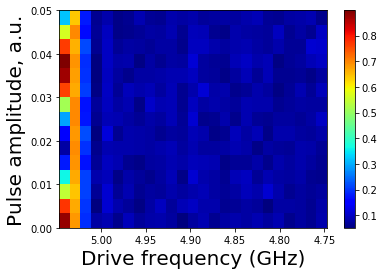

In [78]:
plt.xlabel('Drive frequency (GHz)', fontsize=20)
plt.ylabel('Pulse amplitude, a.u.', fontsize=20)
plt.imshow(chevron_data,
           extent=[drive_lo_freqs.max(), drive_lo_freqs.min(), drive_amps.min(), drive_amps.max()],
           cmap='jet',
           origin='lower', aspect='auto')
plt.colorbar()

---
## More datapoints

In [80]:
num_drive_amps = 15
drive_amps = np.linspace(0.0, 0.05, num_drive_amps)
drive_samples = 128
drive_sigma = 16
print(drive_amps)

num_drive_lo_freqs = 12
drive_lo_freqs = np.linspace(config.qubit_lo_range[0][0] + 0.04, config.qubit_lo_range[0][0], num_drive_lo_freqs)
print(drive_lo_freqs)

[0.         0.00357143 0.00714286 0.01071429 0.01428571 0.01785714
 0.02142857 0.025      0.02857143 0.03214286 0.03571429 0.03928571
 0.04285714 0.04642857 0.05      ]
[4.7869008  4.78326443 4.77962807 4.7759917  4.77235534 4.76871898
 4.76508261 4.76144625 4.75780989 4.75417352 4.75053716 4.7469008 ]


In [65]:
jobs = []
job_ids = []

for drive_lo_freq in drive_lo_freqs:
    schedules = []
    schedule_los = []

    for drive_amp in drive_amps:
        schedule = pulse.Schedule(name='Rabi Experiment at drive amp = %s' % drive_amp)
        schedule |= cmd_def.get('x', qubits=[0])
        rabi_pulse = pulse_lib.gaussian(duration=drive_samples,
                                        amp=drive_amp,
                                        sigma=drive_sigma,
                                        name='rabi_pulse_with_drive_amp_%s' % drive_amp)    
        schedule |= rabi_pulse(system.qubits[0].drive) << schedule.duration
        schedule |= measure << schedule.duration

        schedules.append(schedule)        
        schedule_los.append(pulse.LoConfig({system.qubits[0].drive: drive_lo_freq}))
        
    qobj = assemble(schedules, backend, shots=512, schedule_los=schedule_los)
    job = backend.run(qobj)

    jobs.append(job)
    time.sleep(1)

In [66]:
print([job.job_id() for job in jobs])

['5d8af8e41902110012cc1c98', '5d8af8e9e3b0f200144fce56', '5d8af8efdbac5400132f48a3', '5d8af8f51902110012cc1c9a', '5d8af8fa799d5d0011803231', '5d8af8fe4274d500111b6965', '5d8af9059fa3040011c342ca', '5d8af90adbac5400132f48a5', '5d8af90e29dcfd0011e55930', '5d8af912efc5a500112337f3', '5d8af9171902110012cc1c9c', '5d8af91b29dcfd0011e55932']


In [81]:
job_ids = ['5d8af8e41902110012cc1c98', '5d8af8e9e3b0f200144fce56', '5d8af8efdbac5400132f48a3', '5d8af8f51902110012cc1c9a', '5d8af8fa799d5d0011803231', '5d8af8fe4274d500111b6965', '5d8af9059fa3040011c342ca', '5d8af90adbac5400132f48a5', '5d8af90e29dcfd0011e55930', '5d8af912efc5a500112337f3', '5d8af9171902110012cc1c9c', '5d8af91b29dcfd0011e55932']

jobs = [backend.retrieve_job(job_id) for job_id in job_ids]

for i in range(num_drive_lo_freqs):
    print('Job %s with drive LO frequency %s: %s' % (i, drive_lo_freqs[i], jobs[i].status()))

Job 0 with drive LO frequency 4.786900795223616: JobStatus.DONE
Job 1 with drive LO frequency 4.783264431587252: JobStatus.RUNNING
Job 2 with drive LO frequency 4.779628067950889: JobStatus.RUNNING
Job 3 with drive LO frequency 4.775991704314525: JobStatus.RUNNING
Job 4 with drive LO frequency 4.772355340678161: JobStatus.RUNNING
Job 5 with drive LO frequency 4.7687189770417975: JobStatus.RUNNING
Job 6 with drive LO frequency 4.7650826134054345: JobStatus.RUNNING
Job 7 with drive LO frequency 4.761446249769071: JobStatus.RUNNING
Job 8 with drive LO frequency 4.757809886132707: JobStatus.RUNNING
Job 9 with drive LO frequency 4.754173522496343: JobStatus.RUNNING
Job 10 with drive LO frequency 4.75053715885998: JobStatus.RUNNING
Job 11 with drive LO frequency 4.746900795223616: JobStatus.RUNNING


In [90]:
chevron_data = np.zeros((num_drive_amps, num_drive_lo_freqs), dtype=np.float64)

for i, job in enumerate(jobs):
    result = job.result()

    for j in range(num_drive_amps):
        counts = result.get_counts(j)
        num_ones = sum([freq for (bitstring, freq) in counts.items() if bitstring.endswith('1')])
        chevron_data[j, i] = num_ones / 512

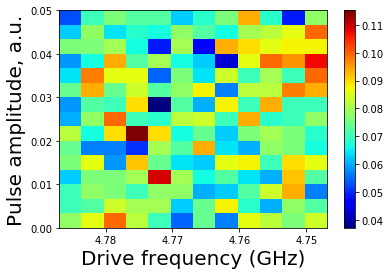

In [91]:
plt.xlabel('Drive frequency (GHz)', fontsize=20)
plt.ylabel('Pulse amplitude, a.u.', fontsize=20)
plt.imshow(chevron_data,
           extent=[drive_lo_freqs.max(), drive_lo_freqs.min(), drive_amps.min(), drive_amps.max()],
           cmap='jet',
           origin='lower', aspect='auto')
plt.colorbar()

---
## meas_level of 1

In [92]:
num_drive_amps = 20
drive_amps = np.linspace(0.0, 0.05, num_drive_amps)
drive_samples = 128
drive_sigma = 16
print(drive_amps)

num_drive_lo_freqs = 15
drive_lo_freqs = np.linspace(config.qubit_lo_range[0][0] + 0.04, config.qubit_lo_range[0][0], num_drive_lo_freqs)
print(drive_lo_freqs)

[0.         0.00263158 0.00526316 0.00789474 0.01052632 0.01315789
 0.01578947 0.01842105 0.02105263 0.02368421 0.02631579 0.02894737
 0.03157895 0.03421053 0.03684211 0.03947368 0.04210526 0.04473684
 0.04736842 0.05      ]
[4.7869008  4.78404365 4.78118651 4.77832937 4.77547222 4.77261508
 4.76975794 4.7669008  4.76404365 4.76118651 4.75832937 4.75547222
 4.75261508 4.74975794 4.7469008 ]


In [93]:
jobs = []
job_ids = []

for drive_lo_freq in drive_lo_freqs:
    schedules = []
    schedule_los = []

    for drive_amp in drive_amps:
        schedule = pulse.Schedule(name='Rabi Experiment at drive amp = %s' % drive_amp)
        schedule |= cmd_def.get('x', qubits=[0])
        rabi_pulse = pulse_lib.gaussian(duration=drive_samples,
                                        amp=drive_amp,
                                        sigma=drive_sigma,
                                        name='rabi_pulse_with_drive_amp_%s' % drive_amp)    
        schedule |= rabi_pulse(system.qubits[0].drive) << schedule.duration
        schedule |= measure << schedule.duration

        schedules.append(schedule)        
        schedule_los.append(pulse.LoConfig({system.qubits[0].drive: drive_lo_freq}))
        
    qobj = assemble(schedules, backend, shots=512, schedule_los=schedule_los, meas_level=1, meas_return='single')
    job = backend.run(qobj)

    jobs.append(job)
    time.sleep(1)

In [94]:
print([job.job_id() for job in jobs])

['5d8b00a3799d5d0011803236', '5d8b00a84274d500111b696b', '5d8b00b2e3b0f200144fce5c', '5d8b00b69fa3040011c342cd', '5d8b00bb9fa3040011c342cf', '5d8b00c1799d5d0011803238', '5d8b00c6799d5d001180323a', '5d8b00cbe3b0f200144fce5e', '5d8b00d01902110012cc1c9f', '5d8b00d5e3b0f200144fce60', '5d8b00d929dcfd0011e55938', '5d8b00dd4274d500111b696d', '5d8b00e229dcfd0011e5593a', '5d8b00e7dbac5400132f48aa', '5d8b00eb29dcfd0011e5593c']


In [138]:
job_ids = ['5d8b00a3799d5d0011803236', '5d8b00a84274d500111b696b', '5d8b00b2e3b0f200144fce5c', '5d8b00b69fa3040011c342cd', '5d8b00bb9fa3040011c342cf', '5d8b00c1799d5d0011803238', '5d8b00c6799d5d001180323a', '5d8b00cbe3b0f200144fce5e', '5d8b00d01902110012cc1c9f', '5d8b00d5e3b0f200144fce60', '5d8b00d929dcfd0011e55938', '5d8b00dd4274d500111b696d', '5d8b00e229dcfd0011e5593a', '5d8b00e7dbac5400132f48aa', '5d8b00eb29dcfd0011e5593c']

jobs = [backend.retrieve_job(job_id) for job_id in job_ids]

for i in range(num_drive_lo_freqs):
    print('Job %s with drive LO frequency %s: %s' % (i, drive_lo_freqs[i], jobs[i].status()))

Job 0 with drive LO frequency 4.786900795223616: JobStatus.DONE
Job 1 with drive LO frequency 4.784043652366473: JobStatus.DONE
Job 2 with drive LO frequency 4.781186509509331: JobStatus.DONE
Job 3 with drive LO frequency 4.778329366652187: JobStatus.DONE
Job 4 with drive LO frequency 4.775472223795044: JobStatus.DONE
Job 5 with drive LO frequency 4.772615080937902: JobStatus.DONE
Job 6 with drive LO frequency 4.769757938080759: JobStatus.DONE
Job 7 with drive LO frequency 4.766900795223616: JobStatus.DONE
Job 8 with drive LO frequency 4.764043652366473: JobStatus.DONE
Job 9 with drive LO frequency 4.76118650950933: JobStatus.DONE
Job 10 with drive LO frequency 4.7583293666521875: JobStatus.DONE
Job 11 with drive LO frequency 4.755472223795045: JobStatus.DONE
Job 12 with drive LO frequency 4.752615080937901: JobStatus.DONE
Job 13 with drive LO frequency 4.749757938080759: JobStatus.DONE
Job 14 with drive LO frequency 4.746900795223616: JobStatus.DONE


In [139]:
chevron_data = np.zeros((num_drive_amps, num_drive_lo_freqs), dtype=np.float64)

for i, job in enumerate(jobs):
    result = job.result()
    
    for j in range(num_drive_amps):
        memory_shots = result.get_memory(j)
        qubit_0_readouts = [np.abs(memory_shot[0]) for memory_shot in memory_shots]
        chevron_data[j, i] = np.average(qubit_0_readouts) * 1e-10

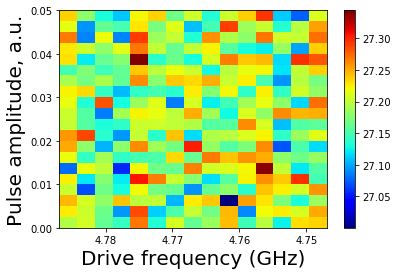

In [140]:
plt.xlabel('Drive frequency (GHz)', fontsize=20)
plt.ylabel('Pulse amplitude, a.u.', fontsize=20)
plt.imshow(chevron_data,
           extent=[drive_lo_freqs.max(), drive_lo_freqs.min(), drive_amps.min(), drive_amps.max()],
           cmap='jet',
           origin='lower', aspect='auto')
plt.colorbar()

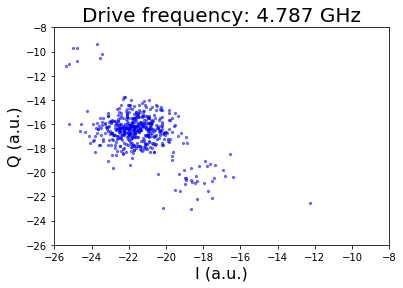

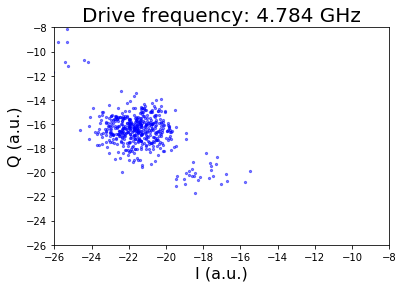

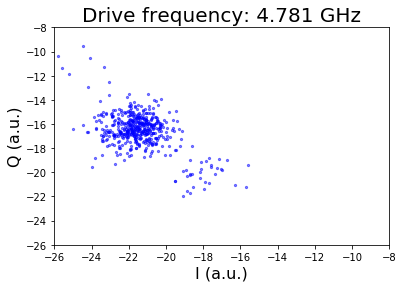

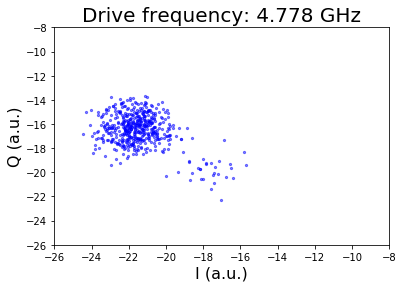

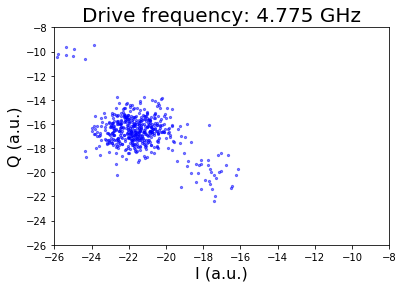

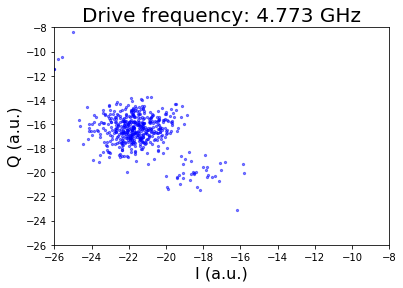

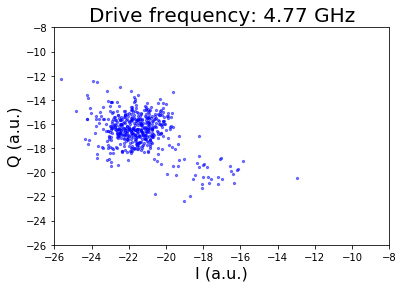

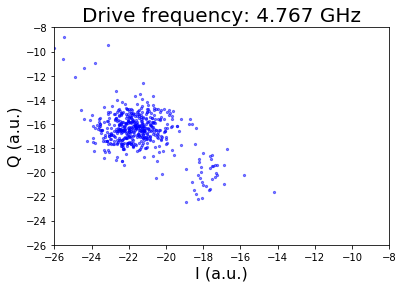

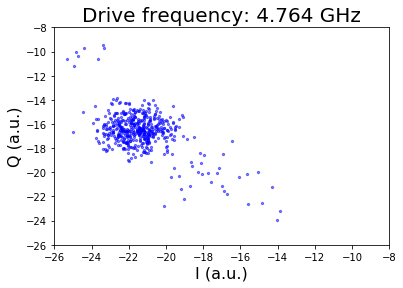

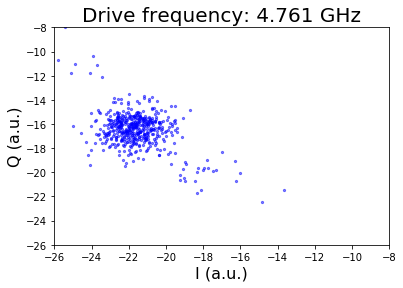

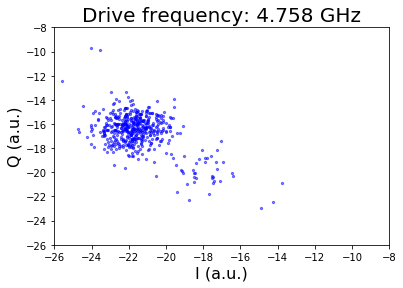

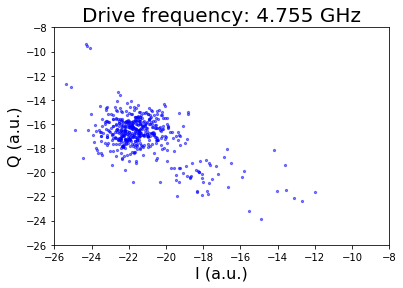

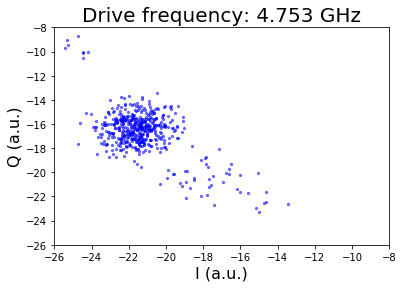

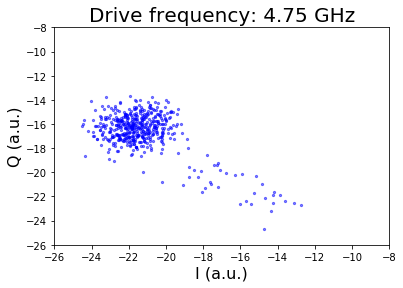

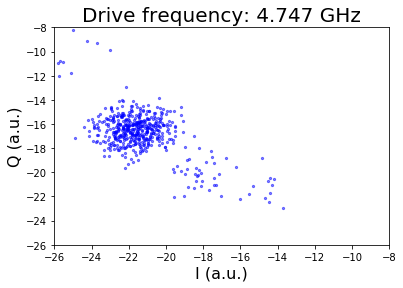

In [144]:
for i, job in enumerate(jobs):  # span different drive frequencies
    result = job.result()
    memory_shots = result.get_memory(19)
    qubit_0_readouts = [memory_shot[0] for memory_shot in memory_shots]

    plt.title('Drive frequency: %s GHz' % np.round(drive_lo_freqs[i],3), fontsize=20)
    plt.xlabel('I (a.u.)', fontsize=16)
    plt.ylabel('Q (a.u.)', fontsize=16)
    plt.xlim(-26, -8)
    plt.ylim(-26, -8)
    plt.scatter(np.real(qubit_0_readouts) * 1e-10, np.imag(qubit_0_readouts) * 1e-10,
                s=5, cmap='viridis',c='blue',alpha=0.5)
    plt.show()

---
## get IQ plot for |0> and for |1>

In [136]:
schedules = []

schedule = pulse.Schedule()
schedule |= measure << schedule.duration
schedules.append(schedule)

schedule = pulse.Schedule()
schedule |= cmd_def.get('x', qubits=[0])
schedule |= measure << schedule.duration
schedules.append(schedule)

qobj = assemble(schedules, backend, shots=512, meas_level=1, meas_return='single')
job = backend.run(qobj)
print(job.job_id())

5d8bb6974274d500111b6a51


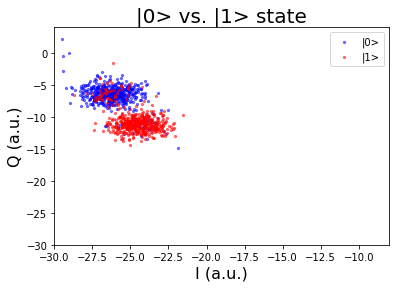

In [171]:
job = backend.retrieve_job('5d8bb6974274d500111b6a51')
result = job.result()

memory_shots = result.get_memory(0)
qubit_0_readouts = [memory_shot[0] for memory_shot in memory_shots]

plt.title('|0> vs. |1> state', fontsize=20)
plt.xlabel('I (a.u.)', fontsize=16)
plt.ylabel('Q (a.u.)', fontsize=16)
plt.xlim(-30, -8)
plt.ylim(-30, 4)
plt.scatter(np.real(qubit_0_readouts) * 1e-10, np.imag(qubit_0_readouts) * 1e-10,
            s=5, cmap='viridis',c='blue',alpha=0.5, label='|0>')

memory_shots = result.get_memory(1)
qubit_0_readouts = [memory_shot[0] for memory_shot in memory_shots]
plt.scatter(np.real(qubit_0_readouts) * 1e-10, np.imag(qubit_0_readouts) * 1e-10,
            s=5, cmap='viridis',c='red',alpha=0.5, label='|1>')

plt.legend(loc='upper right')
plt.show()